# 📈 ML Signal Generator

This notebook implements a machine learning pipeline for predicting BTC/USDT price direction.

## Overview
- **Data Source**: Binance API (historical klines/candlestick data)
- **Target**: Predict whether the next candle will close higher (Up) or lower (Down)
- **Models**: Logistic Regression and Random Forest classifiers
- **Output**: Trained model saved as `best_model.pkl`

## Pipeline Steps
1. Data retrieval with local caching
2. Feature engineering (technical indicators)
3. Model training and evaluation
4. Model selection and export

In [1]:
# ============================================================================
# LOCAL PARQUET CACHE FOR KLINES DATA
# ============================================================================
# Caching mechanism stores downloaded data on disk for faster subsequent access,
# avoiding repeated API calls and improving performance.
#
# Cache files stored in 'data_cache/' directory:
# - {symbol}_{interval}.parquet : OHLCV data
# - {symbol}_{interval}.meta.json : Metadata with timestamp
# ============================================================================

from pathlib import Path
import pandas as pd
import json
from datetime import datetime, timezone

# Directory for cached data files
CACHE_DIR = Path('data_cache')
CACHE_DIR.mkdir(exist_ok=True)


def _cache_path(symbol: str, interval: str) -> Path:
    """Generate file path for cached parquet data."""
    return CACHE_DIR / f"{symbol}_{interval}.parquet"


def _meta_path(symbol: str, interval: str) -> Path:
    """Generate file path for cache metadata."""
    return CACHE_DIR / f"{symbol}_{interval}.meta.json"


def get_klines_cached(symbol: str, interval: str, lookback_candles: int, max_age_minutes: int = 30):
    """
    Retrieve klines data with local caching support.
    
    Checks for valid cached data first; if cache is fresh (within max_age_minutes),
    returns cached data. Otherwise, fetches new data and updates cache.
    
    Args:
        symbol: Trading pair (e.g., 'BTCUSDT')
        interval: Candlestick interval (e.g., '1m')
        lookback_candles: Number of historical candles to retrieve
        max_age_minutes: Maximum cache age before refresh (default: 30)
    
    Returns:
        DataFrame with OHLCV data
    """
    path = _cache_path(symbol, interval)
    meta = _meta_path(symbol, interval)
    now = datetime.now(timezone.utc).timestamp()

    # Check if valid cache exists
    if path.exists() and meta.exists():
        try:
            meta_obj = json.loads(meta.read_text())
            age_min = (now - meta_obj.get('ts', 0)) / 60.0
            if age_min <= max_age_minutes:
                df = pd.read_parquet(path)
                return df
        except Exception:
            pass  # Cache read failed, fetch fresh data

    # Fetch fresh data from Binance API
    klines = get_klines(symbol, interval, lookback_candles)
    df = pd.DataFrame(klines, columns=[
        'timestamp', 'open', 'high', 'low', 'close', 'volume',
        'close_time', 'quote_asset_volume', 'number_of_trades',
        'taker_buy_base_volume', 'taker_buy_quote_volume', 'ignore'
    ])
    
    # Persist to cache
    df.to_parquet(path, index=False)
    meta.write_text(json.dumps({'ts': now}))
    return df

In [2]:
# ============================================================================
# DATA RETRIEVAL AND PREPROCESSING
# ============================================================================
# Handles: API connection, data retrieval, cleaning, feature engineering,
# and initial model training
# ============================================================================

from datetime import timedelta, datetime
from binance.client import Client
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import os

# ----------------------------------------------------------------------------
# API CREDENTIALS
# ----------------------------------------------------------------------------
# Best practice: Use environment variables for API credentials
# WARNING: Never commit real API keys to version control!

api_key = os.getenv('BINANCE_API_KEY')
api_secret = os.getenv('BINANCE_API_SECRET')

# Fallback for development (replace with your keys or use env vars)
if not api_key:
    api_key = 'YOUR_API_KEY_HERE'
if not api_secret:
    api_secret = 'YOUR_API_SECRET_HERE'

# Initialize Binance client (public endpoints don't require auth)
client = Client(api_key, api_secret) if api_key and api_secret else Client()

# ----------------------------------------------------------------------------
# TRADING PARAMETERS
# ----------------------------------------------------------------------------
symbol = "BTCUSDT"          # Trading pair to analyze
interval = '1m'              # Candlestick interval
lookback_candles = 50000     # Historical candles to fetch


def get_klines(symbol: str, interval: str, lookback_candles: int):
    """
    Fetch historical klines (candlestick) data from Binance API.
    
    Args:
        symbol: Trading pair symbol (e.g., 'BTCUSDT')
        interval: Candlestick interval (e.g., '1m', '5m', '1h')
        lookback_candles: Number of historical candles
    
    Returns:
        List of klines data from Binance API
    """
    if interval.endswith('m'):
        minutes_per_candle = int(interval.replace('m', ''))
    else:
        minutes_per_candle = 1
    
    total_minutes = lookback_candles * minutes_per_candle
    hours = max(1, total_minutes // 60)
    start_str = f"{hours} hours ago UTC"

    klines = client.get_historical_klines(
        symbol=symbol,
        interval=interval,
        start_str=start_str
    )
    return klines


# Retrieve data with caching
df = get_klines_cached(symbol, interval, lookback_candles)

# Handle raw list from cache
if not isinstance(df, pd.DataFrame):
    df = pd.DataFrame(df, columns=[
        'timestamp', 'open', 'high', 'low', 'close', 'volume',
        'close_time', 'quote_asset_volume', 'number_of_trades',
        'taker_buy_base_volume', 'taker_buy_quote_volume', 'ignore'
    ])

# ----------------------------------------------------------------------------
# DATA PREPROCESSING
# ----------------------------------------------------------------------------
group = df[["timestamp", "open", "high", "low", "close", "volume"]].copy()

# Convert timestamp to datetime
group["timestamp"] = pd.to_datetime(group["timestamp"], unit='ms')
group = group.set_index("timestamp")

# Convert to float32 for memory efficiency
for col in ["open", "high", "low", "close", "volume"]:
    group[col] = group[col].astype('float32')


def detect_outliers(data):
    """
    Detect outliers using IQR (Interquartile Range) method.
    Values outside Q1-1.5*IQR to Q3+1.5*IQR are flagged.
    """
    outlier_flags = []
    q3, q1 = np.percentile(data, [75, 25])
    IQR = q3 - q1
    lower_bound = q1 - 1.5 * IQR
    upper_bound = q3 + 1.5 * IQR
    
    for value in data:
        outlier_flags.append(value < lower_bound or value > upper_bound)
    return outlier_flags


# Remove outliers
group["outlier"] = detect_outliers(group["close"])
group = group[group["outlier"] == False].copy()

# ----------------------------------------------------------------------------
# FEATURE ENGINEERING - Basic Indicators
# ----------------------------------------------------------------------------
group['PrevClose'] = group["close"].shift(1)                    # Lagged close
group["High-Low"] = group["high"] - group["low"]               # Volatility
group["Open-Close"] = group["open"] - group["close"]           # Candle body
group["MA10"] = group["close"].rolling(window=10).mean()       # Short MA
group["MA50"] = group["close"].rolling(window=50).mean()       # Medium MA

# ----------------------------------------------------------------------------
# TARGET VARIABLE - Direction of next candle
# ----------------------------------------------------------------------------
group["Target_Close"] = group["close"].shift(-1)
group["Direction"] = np.sign(group["Target_Close"] - group["close"])
group = group.dropna()
group = group[(group["Direction"] == 1) | (group["Direction"] == -1)]
group["Direction"] = group["Direction"].apply(lambda x: "Up" if x == 1 else "Down")

print(group)

# ----------------------------------------------------------------------------
# INITIAL MODEL TRAINING
# ----------------------------------------------------------------------------
feature_cols_basic = ['PrevClose', "High-Low", "Open-Close", "MA10", "MA50", "volume"]
tscv = TimeSeriesSplit(n_splits=10)

# Temporal split (no shuffle to prevent data leakage)
grouptrain, grouptest = train_test_split(group, test_size=0.2, random_state=123, shuffle=False)

xtrain = grouptrain[feature_cols_basic].values
ytrain = grouptrain["Direction"].values
xtest = grouptest[feature_cols_basic].values
ytest = grouptest["Direction"].values

# Standardize features
scaler = StandardScaler()
xtrain_scaled = scaler.fit_transform(xtrain)
xtest_scaled = scaler.transform(xtest)

# Logistic Regression
model1 = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=123)
model1.fit(xtrain_scaled, ytrain)

# Random Forest
model2 = RandomForestClassifier(
    n_estimators=50, max_depth=10, min_samples_split=10,
    min_samples_leaf=5, max_features='sqrt', random_state=123
)
model2.fit(xtrain, ytrain)

# Cross-validation
cv_scores_lr = cross_val_score(model1, xtrain_scaled, ytrain, cv=tscv, scoring='accuracy')
cv_scores_rf = cross_val_score(model2, xtrain, ytrain, cv=tscv, scoring='accuracy')

print("\n=== Model Performance ===")
print(f"LR Train Accuracy: {model1.score(xtrain_scaled, ytrain):.3f}")
print(f"RF Train Accuracy: {model2.score(xtrain, ytrain):.3f}")
print(f"LR CV Score: {cv_scores_lr.mean():.3f} (+/- {cv_scores_lr.std() * 2:.3f})")
print(f"RF CV Score: {cv_scores_rf.mean():.3f} (+/- {cv_scores_rf.std() * 2:.3f})")

# Test predictions
y_pred1 = model1.predict(xtest_scaled)
y_pred2 = model2.predict(xtest)

print("\n=== Logistic Regression (Test Set) ===")
report_lr = classification_report(ytest, y_pred1, output_dict=True)
print(classification_report(ytest, y_pred1))

print("=== Random Forest (Test Set) ===")
report_rf = classification_report(ytest, y_pred2, output_dict=True)
print(classification_report(ytest, y_pred2))

# Model selection based on F1-score for 'Up' class
def select_best_model(report_lr, report_rf):
    f1_lr = report_lr['Up']['f1-score']
    f1_rf = report_rf['Up']['f1-score']
    if f1_lr >= f1_rf:
        return "Logistic Regression", f1_lr, f1_rf
    return "Random Forest", f1_rf, f1_lr

model_name, best_f1, other_f1 = select_best_model(report_lr, report_rf)
print(f"\n--- Final Decision ---")
print(f"Selected Model: {model_name} (F1: {best_f1:.3f} vs {other_f1:.3f})")

/Users/yanis.calvo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


                             open          high           low         close  \
timestamp                                                                     
2025-11-13 19:09:00  98367.710938  98575.937500  98347.867188  98537.101562   
2025-11-13 19:10:00  98537.101562  98672.679688  98506.773438  98672.679688   
2025-11-13 19:11:00  98672.671875  98768.046875  98626.328125  98662.093750   
2025-11-13 19:12:00  98662.093750  98736.609375  98569.703125  98595.601562   
2025-11-13 19:13:00  98595.601562  98777.726562  98595.593750  98750.687500   
...                           ...           ...           ...           ...   
2025-12-17 11:11:00  86715.023438  86765.687500  86715.023438  86762.726562   
2025-12-17 11:12:00  86762.718750  86770.210938  86730.179688  86763.679688   
2025-12-17 11:13:00  86763.687500  86852.531250  86763.679688  86852.523438   
2025-12-17 11:14:00  86852.531250  86860.007812  86825.601562  86844.578125   
2025-12-17 11:15:00  86844.578125  86892.421875  868

In [3]:
# ============================================================================
# ADVANCED ML PIPELINE WITH TECHNICAL INDICATORS
# ============================================================================
# Extended features: RSI, MACD, ATR, Bollinger Bands
# Proper preprocessing and model persistence for deployment
# ============================================================================

import warnings
warnings.filterwarnings('ignore')

import pandas_ta as ta
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from joblib import dump

ohlcv = group.copy()


def add_technical_indicators(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add technical indicators to DataFrame.
    
    Indicators added:
    - Returns (1, 5, 15 periods) - Momentum
    - RSI (14) - Relative Strength Index
    - MACD - Trend indicator
    - ATR (14) - Volatility
    - Bollinger Bands - Volatility bands
    """
    df = df.copy()
    
    # Momentum - Price returns
    df['ret_1'] = df['close'].pct_change(1)
    df['ret_5'] = df['close'].pct_change(5)
    df['ret_15'] = df['close'].pct_change(15)
    
    # Volume (log-transformed)
    df['log_vol'] = np.log1p(df['volume'])
    
    # RSI - Momentum oscillator (>70=overbought, <30=oversold)
    df['rsi_14'] = ta.rsi(df['close'], length=14)
    
    # MACD - Trend following momentum
    macd = ta.macd(df['close'], fast=12, slow=26, signal=9)
    if macd is not None and isinstance(macd, pd.DataFrame):
        macd_cols = macd.columns.tolist()
        if len(macd_cols) >= 3:
            df['macd'] = macd.iloc[:, 0]
            df['macd_signal'] = macd.iloc[:, 1]
            df['macd_hist'] = macd.iloc[:, 2]
    else:
        df['macd'] = df['macd_signal'] = df['macd_hist'] = np.nan
    
    # ATR - Volatility measurement
    df['atr_14'] = ta.atr(df['high'], df['low'], df['close'], length=14)
    
    # Bollinger Bands - Volatility and mean reversion
    bb = ta.bbands(df['close'], length=20, std=2.0)
    if isinstance(bb, pd.DataFrame) and bb.shape[1] >= 3:
        bb_cols = bb.columns.tolist()
        df['bb_low'] = bb[bb_cols[0]]
        df['bb_mid'] = bb[bb_cols[1]] if len(bb_cols) > 1 else bb[bb_cols[0]]
        df['bb_high'] = bb[bb_cols[2]] if len(bb_cols) > 2 else bb[bb_cols[0]]
        df['bb_width'] = (df['bb_high'] - df['bb_low']) / df['bb_mid'].replace(0, np.nan)
        df['bb_percent'] = (df['close'] - df['bb_low']) / (df['bb_high'] - df['bb_low']).replace(0, np.nan)
    else:
        df['bb_low'] = df['bb_mid'] = df['bb_high'] = df['bb_width'] = df['bb_percent'] = np.nan
    
    return df


# Apply indicators
feat_df = add_technical_indicators(ohlcv)

# Target variable
feat_df['target_close'] = feat_df['close'].shift(-1)
feat_df['Direction'] = np.where(feat_df['target_close'] > feat_df['close'], 'Up', 'Down')

# Feature columns
feature_cols = [
    'PrevClose', 'High-Low', 'Open-Close', 'MA10', 'MA50', 'volume',
    'ret_1', 'ret_5', 'ret_15', 'log_vol', 'rsi_14', 'macd', 'macd_signal',
    'macd_hist', 'atr_14', 'bb_low', 'bb_mid', 'bb_high', 'bb_width', 'bb_percent'
]

# Handle missing columns
for col in feature_cols:
    if col not in feat_df.columns:
        feat_df[col] = 0.0

# Clean data
feat_df = feat_df[feature_cols + ['Direction']].replace([np.inf, -np.inf], np.nan).dropna()
print(f"Data after cleaning: {len(feat_df)} rows, {len(feature_cols)} features")

# Temporal split (80/20)
n = len(feat_df)
split_idx = int(n * 0.8)
train_df = feat_df.iloc[:split_idx]
test_df = feat_df.iloc[split_idx:]

X_train = train_df[feature_cols].values
y_train = train_df['Direction'].values
X_test = test_df[feature_cols].values
y_test = test_df['Direction'].values

print(f"Train: {len(X_train)}, Test: {len(X_test)}")

# Model pipelines
pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(
        solver='lbfgs', penalty='l2', C=1.0, max_iter=1000,
        class_weight='balanced', random_state=123
    ))
])

pipe_rf = Pipeline([
    ('clf', RandomForestClassifier(
        n_estimators=50, max_depth=10, min_samples_leaf=5,
        max_features='sqrt', class_weight='balanced_subsample', random_state=123
    ))
])

# Train
print("Training models...")
pipe_lr.fit(X_train, y_train)
print("✓ LR trained")
pipe_rf.fit(X_train, y_train)
print("✓ RF trained")

best_lr, best_rf = pipe_lr, pipe_rf

# Get class indices
lr_up_idx = np.where(best_lr.named_steps['clf'].classes_ == 'Up')[0][0]
rf_up_idx = np.where(best_rf.named_steps['clf'].classes_ == 'Up')[0][0]

# Predictions
proba_lr = best_lr.predict_proba(X_test)[:, lr_up_idx]
proba_rf = best_rf.predict_proba(X_test)[:, rf_up_idx]
y_pred_lr = np.where(proba_lr >= 0.5, 'Up', 'Down')
y_pred_rf = np.where(proba_rf >= 0.5, 'Up', 'Down')

# Metrics
metrics = {}
for name, y_pred in [('LR', y_pred_lr), ('RF', y_pred_rf)]:
    metrics[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'f1_up': f1_score(y_test, y_pred, pos_label='Up', zero_division=0),
    }

print("\n=== Out-of-Sample Results ===")
for k, v in metrics.items():
    print(f"{k}: acc={v['accuracy']:.3f}, f1_up={v['f1_up']:.3f}")

# Select and save best model
best_name = max(metrics.keys(), key=lambda k: metrics[k]['f1_up'])
best_estimator = best_lr if best_name == 'LR' else best_rf
print(f"\nSelected: {best_name}")

dump(best_estimator, 'best_model.pkl')
print("Model saved to best_model.pkl")

Data after cleaning: 47497 rows, 20 features
Train: 37997, Test: 9500
Training models...
✓ LR trained
✓ RF trained

=== Out-of-Sample Results ===
LR: acc=0.525, f1_up=0.570
RF: acc=0.510, f1_up=0.538

Selected: LR
Model saved to best_model.pkl


In [4]:
# ============================================================================
# MODEL COMPARISON AND ANALYSIS
# ============================================================================

print("=== Model Comparison ===\n")
for name in ['LR', 'RF']:
    print(f"{name}: Acc={metrics[name]['accuracy']:.3f}, F1_Up={metrics[name]['f1_up']:.3f}")

# Feature importance (RF only)
if best_name == 'RF':
    feat_imp = best_rf.named_steps['clf'].feature_importances_
    sorted_idx = np.argsort(feat_imp)[::-1][:10]
    print("\n=== Top 10 Features ===")
    for i, idx in enumerate(sorted_idx, 1):
        print(f"{i}. {feature_cols[idx]}: {feat_imp[idx]:.4f}")

=== Model Comparison ===

LR: Acc=0.525, F1_Up=0.570
RF: Acc=0.510, F1_Up=0.538


In [5]:
# ============================================================================
# WALK-FORWARD VALIDATION
# ============================================================================
# Simulates real trading by expanding training window over time
# ============================================================================

from sklearn.base import clone

X_all = feat_df[feature_cols].values
y_all = feat_df['Direction'].values

wf_cv = TimeSeriesSplit(n_splits=6)
f1_scores = []

print("Walk-Forward Validation:")
for i, (tr_idx, te_idx) in enumerate(wf_cv.split(X_all)):
    est = clone(best_estimator)
    est.fit(X_all[tr_idx], y_all[tr_idx])
    y_pred = est.predict(X_all[te_idx])
    f1 = f1_score(y_all[te_idx], y_pred, pos_label='Up', zero_division=0)
    f1_scores.append(f1)
    print(f"Fold {i+1}: F1_Up={f1:.3f}")

print(f"\nMean F1_Up: {np.mean(f1_scores):.3f} (+/- {np.std(f1_scores):.3f})")

Walk-Forward Validation:
Fold 1: F1_Up=0.646
Fold 2: F1_Up=0.568
Fold 3: F1_Up=0.565
Fold 4: F1_Up=0.556
Fold 5: F1_Up=0.544
Fold 6: F1_Up=0.583

Mean F1_Up: 0.577 (+/- 0.033)


In [6]:
# ============================================================================
# INFERENCE - TRADING DECISION FOR LATEST CANDLE
# ============================================================================

from joblib import load

model = load('best_model.pkl')
last_features = feat_df.iloc[[-1]][feature_cols].values
proba_up = model.predict_proba(last_features)[:, 1][0]
decision = 'UP (BUY)' if proba_up >= 0.5 else 'DOWN (SELL)'

print(f"Probability 'Up': {proba_up:.4f}")
print(f"Decision: {decision}")

Probability 'Up': 0.4625
Decision: DOWN (SELL)


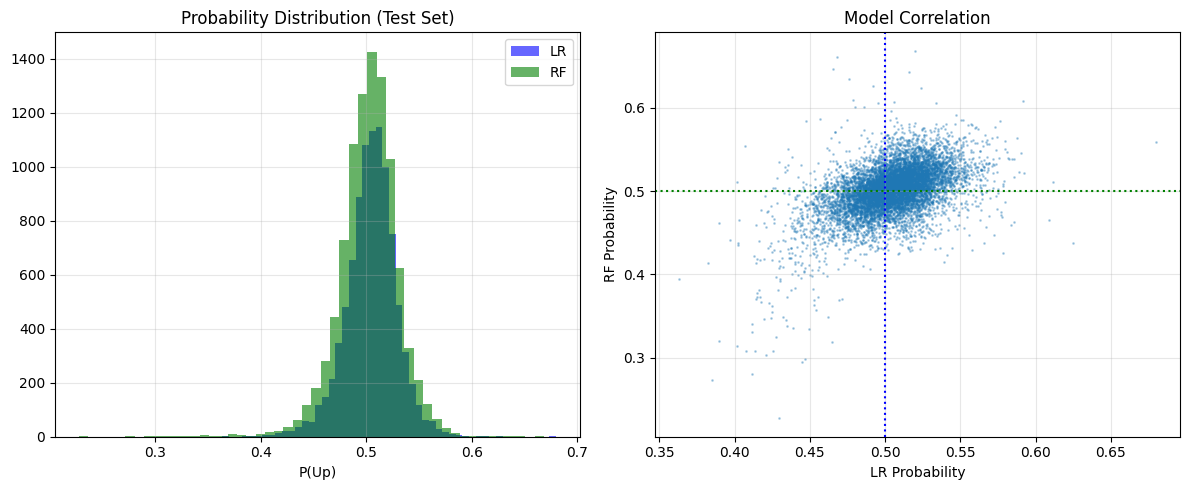

Selected Model: LR


In [7]:
# ============================================================================
# VISUALIZATION
# ============================================================================

import matplotlib.pyplot as plt

# Probability distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(proba_lr, bins=50, alpha=0.6, label='LR', color='blue')
axes[0].hist(proba_rf, bins=50, alpha=0.6, label='RF', color='green')
axes[0].set_title('Probability Distribution (Test Set)')
axes[0].set_xlabel('P(Up)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].scatter(proba_lr, proba_rf, alpha=0.3, s=1)
axes[1].axhline(0.5, color='g', linestyle=':')
axes[1].axvline(0.5, color='b', linestyle=':')
axes[1].set_xlabel('LR Probability')
axes[1].set_ylabel('RF Probability')
axes[1].set_title('Model Correlation')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Selected Model: {best_name}")